## Training for Synth Paper 2022

### Loading data

In [1]:
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import timm

import albumentations as albu
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# helper function for data visualization
def visualize(label, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        plt.title(f'{name.title()} | GT: {label}')
        plt.imshow(image)
    plt.show()

### Data Preparation

In [4]:
df = pd.read_csv('synth_paper_data.csv')
df['class'] = df['class'].astype('category')

In [7]:
df.sample(5)

,file_path,file_name,source,split,class,label_encoded
10113,../../data/generated_data/cs_uu/nb/sample_8107...,sample_8107.png,Synth,train,NB,1
4846,../../data/generated_data/cs_uu/nb/sample_5920...,sample_5920.png,Synth,train,NB,1
22381,../../data/Covidx/data_with_classes/train/norm...,95a7b129-0666-45bb-8e95-68c4a352d61f.png,Covidx,train,NB,1
14475,../../data/generated_data/cs_uu/covid/sample_7...,sample_7805.png,Synth,train,C,0
13835,../../data/generated_data/cs_uu/covid/sample_2...,sample_2800.png,Synth,train,C,0


In [9]:
df['source'].unique()

array(['UKU', 'Synth', 'Covidx'], dtype=object)

Dataloader:

In [13]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations."""
    
    def __init__(
            self,
            df, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.df = df.reset_index(drop=True)
        self.ids = self.df.loc[:,'file_path'].values
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.ids[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        
        label = self.df.loc[i,'label_encoded']
        
        return image, label
        
    def __len__(self):
        return len(self.ids)

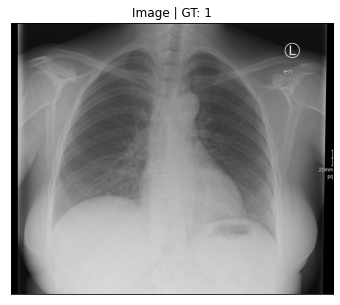

In [14]:
dataset = Dataset(df.loc[df['source']=='UKU_old_split',:])

image, label = dataset[3] # get some sample
visualize(
    label=label,
    image=image
)

### Augmentations

In [15]:
image_size = 224

In [16]:
def get_training_augmentation():
    train_transform = [
        
        albu.RandomResizedCrop(height=image_size, width=image_size, scale=(0.25, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1, p=1.0),
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),


        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(384, 480)
        albu.Resize(image_size, image_size),
        #albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD,max_pixel_value=255.0),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

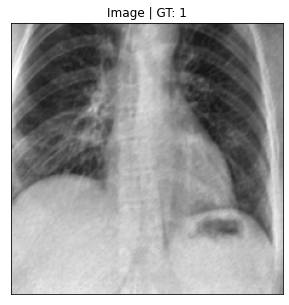

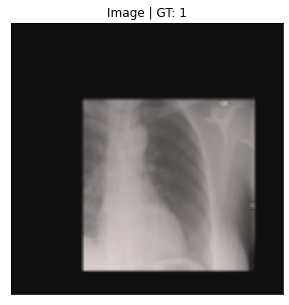

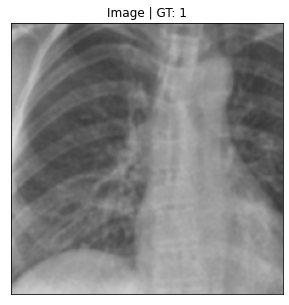

In [17]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    df.loc[df['source']=='UKU_old_split',:], 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, label = augmented_dataset[3]
    visualize(label=label,image=image)

### Create model and train

Define model

In [21]:
dropout = False
dropout_percent = 0.5
num_classes = 2

In [22]:
model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
num_ftrs = model.get_classifier().in_features
if dropout:
    model.fc = nn.Sequential(
                            nn.Dropout(dropout_percent),
                            nn.Linear(num_ftrs,num_classes)
    )
else:
    model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device) 

Define Loss function and optimizer

In [23]:
epochs = 40
val_loss_min = np.Inf

In [24]:
criterion = nn.CrossEntropyLoss()

In [34]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs-1)

scaler = torch.cuda.amp.GradScaler()

In [35]:
train_dataset = Dataset(
    df.loc[(df['source']=='UKU_old_split') & (df['split']=='train'),:],
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing()
)

valid_dataset = Dataset(
    df.loc[(df['source']=='UKU_old_split') & (df['split']=='test'),:], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [36]:
ckpt_dir = './models'
CHECKPOINT = f'{ckpt_dir}/resnet50_synth_uku.pth'

In [38]:
for epoch in range(epochs):
    model.train()
    train_loss = []
    train_running_corrects = 0
    val_running_corrects = 0
    
    loop = tqdm(train_loader)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            train_loss.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            #_,labels = torch.max(labels.data, 1)
            train_running_corrects += torch.sum(predicted == labels.data)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()

        loop.set_description('Epoch {:02d}/{:02d} | LR: {:.5f}'.format(epoch, epochs-1, optimizer.param_groups[0]['lr']))
        loop.set_postfix(loss=np.mean(train_loss))

    train_loss = np.mean(train_loss)
    train_epoch_acc = train_running_corrects.double() / len(train_loader.dataset)
    
    model.eval()

    val_loss = 0

    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast(), torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            #_,labels = torch.max(labels.data, 1)
            val_running_corrects += torch.sum(predicted == labels.data)

    val_loss /= len(valid_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(valid_loader.dataset)
    
    print(f'train loss: {train_loss:.5f} | train acc: {train_epoch_acc:.3f} | val_loss: {val_loss:.5f} | val acc: {val_epoch_acc:.3f}')
    
    if val_loss < val_loss_min:
            print(f'Valid loss improved from {val_loss_min:.5f} to {val_loss:.5f} saving model to {CHECKPOINT}')
            val_loss_min = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), CHECKPOINT)
    
    print(f'Best epoch {best_epoch} | val loss min: {val_loss_min:.5f}')

Epoch 00/39 | LR: 0.00005: 100%|██████████| 19/19 [00:04<00:00,  4.20it/s, loss=0.517]
100%|██████████| 40/40 [00:01<00:00, 31.38it/s]


train loss: 0.51699 | train acc: 0.700 | val_loss: 1.01580 | val acc: 0.500
Valid loss improved from inf to 1.01580 saving model to ./models/resnet50_synth_uku.pth
Best epoch 0 | val loss min: 1.01580


Epoch 01/39 | LR: 0.00000: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s, loss=0.387]
100%|██████████| 40/40 [00:01<00:00, 34.55it/s]


train loss: 0.38665 | train acc: 0.870 | val_loss: 0.54094 | val acc: 0.800
Valid loss improved from 1.01580 to 0.54094 saving model to ./models/resnet50_synth_uku.pth
Best epoch 1 | val loss min: 0.54094


Epoch 02/39 | LR: 0.00004: 100%|██████████| 19/19 [00:04<00:00,  4.46it/s, loss=0.381]
100%|██████████| 40/40 [00:01<00:00, 32.39it/s]


train loss: 0.38073 | train acc: 0.850 | val_loss: 0.41360 | val acc: 0.800
Valid loss improved from 0.54094 to 0.41360 saving model to ./models/resnet50_synth_uku.pth
Best epoch 2 | val loss min: 0.41360


Epoch 03/39 | LR: 0.00010: 100%|██████████| 19/19 [00:04<00:00,  4.63it/s, loss=0.368]
100%|██████████| 40/40 [00:01<00:00, 31.84it/s]


train loss: 0.36758 | train acc: 0.857 | val_loss: 0.14540 | val acc: 1.000
Valid loss improved from 0.41360 to 0.14540 saving model to ./models/resnet50_synth_uku.pth
Best epoch 3 | val loss min: 0.14540


Epoch 04/39 | LR: 0.00006: 100%|██████████| 19/19 [00:04<00:00,  4.54it/s, loss=0.293]
100%|██████████| 40/40 [00:01<00:00, 33.06it/s]


train loss: 0.29307 | train acc: 0.877 | val_loss: 0.07625 | val acc: 0.975
Valid loss improved from 0.14540 to 0.07625 saving model to ./models/resnet50_synth_uku.pth
Best epoch 4 | val loss min: 0.07625


Epoch 05/39 | LR: 0.00000: 100%|██████████| 19/19 [00:04<00:00,  4.48it/s, loss=0.26] 
100%|██████████| 40/40 [00:01<00:00, 34.04it/s]


train loss: 0.25975 | train acc: 0.901 | val_loss: 0.05558 | val acc: 1.000
Valid loss improved from 0.07625 to 0.05558 saving model to ./models/resnet50_synth_uku.pth
Best epoch 5 | val loss min: 0.05558


Epoch 06/39 | LR: 0.00004: 100%|██████████| 19/19 [00:04<00:00,  4.22it/s, loss=0.283]
100%|██████████| 40/40 [00:01<00:00, 33.78it/s]


train loss: 0.28270 | train acc: 0.891 | val_loss: 0.04984 | val acc: 1.000
Valid loss improved from 0.05558 to 0.04984 saving model to ./models/resnet50_synth_uku.pth
Best epoch 6 | val loss min: 0.04984


Epoch 07/39 | LR: 0.00010: 100%|██████████| 19/19 [00:04<00:00,  4.46it/s, loss=0.235]
100%|██████████| 40/40 [00:01<00:00, 34.47it/s]


train loss: 0.23461 | train acc: 0.908 | val_loss: 0.11702 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 08/39 | LR: 0.00007: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, loss=0.292]
100%|██████████| 40/40 [00:01<00:00, 32.48it/s]


train loss: 0.29247 | train acc: 0.874 | val_loss: 0.07495 | val acc: 1.000
Best epoch 6 | val loss min: 0.04984


Epoch 09/39 | LR: 0.00000: 100%|██████████| 19/19 [00:04<00:00,  4.13it/s, loss=0.237]
100%|██████████| 40/40 [00:01<00:00, 33.19it/s]


train loss: 0.23743 | train acc: 0.904 | val_loss: 0.12956 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 10/39 | LR: 0.00003: 100%|██████████| 19/19 [00:04<00:00,  4.49it/s, loss=0.264]
100%|██████████| 40/40 [00:01<00:00, 33.23it/s]


train loss: 0.26355 | train acc: 0.881 | val_loss: 0.09785 | val acc: 1.000
Best epoch 6 | val loss min: 0.04984


Epoch 11/39 | LR: 0.00009: 100%|██████████| 19/19 [00:04<00:00,  4.19it/s, loss=0.245]
100%|██████████| 40/40 [00:01<00:00, 33.69it/s]


train loss: 0.24453 | train acc: 0.908 | val_loss: 0.13070 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 12/39 | LR: 0.00008: 100%|██████████| 19/19 [00:04<00:00,  4.47it/s, loss=0.189]
100%|██████████| 40/40 [00:01<00:00, 34.39it/s]


train loss: 0.18890 | train acc: 0.935 | val_loss: 0.09600 | val acc: 1.000
Best epoch 6 | val loss min: 0.04984


Epoch 13/39 | LR: 0.00001: 100%|██████████| 19/19 [00:04<00:00,  4.50it/s, loss=0.182]
100%|██████████| 40/40 [00:01<00:00, 34.03it/s]


train loss: 0.18164 | train acc: 0.949 | val_loss: 0.10046 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 14/39 | LR: 0.00002: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, loss=0.229]
100%|██████████| 40/40 [00:01<00:00, 34.11it/s]


train loss: 0.22859 | train acc: 0.925 | val_loss: 0.10258 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 15/39 | LR: 0.00009: 100%|██████████| 19/19 [00:04<00:00,  4.23it/s, loss=0.266]
100%|██████████| 40/40 [00:01<00:00, 34.96it/s]


train loss: 0.26569 | train acc: 0.891 | val_loss: 0.16920 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 16/39 | LR: 0.00008: 100%|██████████| 19/19 [00:04<00:00,  4.57it/s, loss=0.202]
100%|██████████| 40/40 [00:01<00:00, 34.79it/s]


train loss: 0.20152 | train acc: 0.922 | val_loss: 0.20277 | val acc: 0.900
Best epoch 6 | val loss min: 0.04984


Epoch 17/39 | LR: 0.00001: 100%|██████████| 19/19 [00:04<00:00,  4.43it/s, loss=0.225]
100%|██████████| 40/40 [00:01<00:00, 32.45it/s]


train loss: 0.22503 | train acc: 0.925 | val_loss: 0.12895 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 18/39 | LR: 0.00002: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, loss=0.168]
100%|██████████| 40/40 [00:01<00:00, 33.90it/s]


train loss: 0.16845 | train acc: 0.935 | val_loss: 0.12676 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 19/39 | LR: 0.00008: 100%|██████████| 19/19 [00:04<00:00,  4.16it/s, loss=0.177]
100%|██████████| 40/40 [00:01<00:00, 34.95it/s]


train loss: 0.17664 | train acc: 0.942 | val_loss: 0.08234 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 20/39 | LR: 0.00009: 100%|██████████| 19/19 [00:04<00:00,  4.39it/s, loss=0.168]
100%|██████████| 40/40 [00:01<00:00, 37.17it/s]


train loss: 0.16785 | train acc: 0.925 | val_loss: 0.11382 | val acc: 0.925
Best epoch 6 | val loss min: 0.04984


Epoch 21/39 | LR: 0.00002: 100%|██████████| 19/19 [00:04<00:00,  4.59it/s, loss=0.226]
100%|██████████| 40/40 [00:01<00:00, 36.86it/s]


train loss: 0.22646 | train acc: 0.918 | val_loss: 0.09954 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 22/39 | LR: 0.00001: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s, loss=0.165]
100%|██████████| 40/40 [00:01<00:00, 37.88it/s]


train loss: 0.16538 | train acc: 0.935 | val_loss: 0.10087 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 23/39 | LR: 0.00008: 100%|██████████| 19/19 [00:04<00:00,  4.27it/s, loss=0.171]
100%|██████████| 40/40 [00:01<00:00, 36.05it/s]


train loss: 0.17130 | train acc: 0.925 | val_loss: 0.10889 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 24/39 | LR: 0.00009: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, loss=0.217]
100%|██████████| 40/40 [00:01<00:00, 37.82it/s]


train loss: 0.21717 | train acc: 0.932 | val_loss: 0.07457 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 25/39 | LR: 0.00003: 100%|██████████| 19/19 [00:04<00:00,  4.52it/s, loss=0.164]
100%|██████████| 40/40 [00:01<00:00, 39.34it/s]


train loss: 0.16422 | train acc: 0.949 | val_loss: 0.15031 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 26/39 | LR: 0.00001: 100%|██████████| 19/19 [00:04<00:00,  4.45it/s, loss=0.191]
100%|██████████| 40/40 [00:01<00:00, 38.10it/s]


train loss: 0.19139 | train acc: 0.935 | val_loss: 0.09386 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 27/39 | LR: 0.00007: 100%|██████████| 19/19 [00:04<00:00,  4.54it/s, loss=0.245]
100%|██████████| 40/40 [00:01<00:00, 38.68it/s]


train loss: 0.24487 | train acc: 0.928 | val_loss: 0.05631 | val acc: 1.000
Best epoch 6 | val loss min: 0.04984


Epoch 28/39 | LR: 0.00010: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, loss=0.172]
100%|██████████| 40/40 [00:01<00:00, 38.56it/s]


train loss: 0.17217 | train acc: 0.935 | val_loss: 0.10020 | val acc: 0.950
Best epoch 6 | val loss min: 0.04984


Epoch 29/39 | LR: 0.00003: 100%|██████████| 19/19 [00:04<00:00,  4.47it/s, loss=0.179]
100%|██████████| 40/40 [00:01<00:00, 38.27it/s]


train loss: 0.17950 | train acc: 0.928 | val_loss: 0.07547 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 30/39 | LR: 0.00000: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, loss=0.149]
100%|██████████| 40/40 [00:01<00:00, 37.80it/s]


train loss: 0.14872 | train acc: 0.952 | val_loss: 0.09210 | val acc: 0.925
Best epoch 6 | val loss min: 0.04984


Epoch 31/39 | LR: 0.00006: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s, loss=0.148]
100%|██████████| 40/40 [00:01<00:00, 37.79it/s]


train loss: 0.14752 | train acc: 0.949 | val_loss: 0.05828 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 32/39 | LR: 0.00010: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s, loss=0.17] 
100%|██████████| 40/40 [00:01<00:00, 37.24it/s]


train loss: 0.16998 | train acc: 0.945 | val_loss: 0.09834 | val acc: 0.975
Best epoch 6 | val loss min: 0.04984


Epoch 33/39 | LR: 0.00004: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s, loss=0.177]
100%|██████████| 40/40 [00:01<00:00, 37.23it/s]


train loss: 0.17703 | train acc: 0.935 | val_loss: 0.01727 | val acc: 1.000
Valid loss improved from 0.04984 to 0.01727 saving model to ./models/resnet50_synth_uku.pth
Best epoch 33 | val loss min: 0.01727


Epoch 34/39 | LR: 0.00000: 100%|██████████| 19/19 [00:03<00:00,  4.84it/s, loss=0.128]
100%|██████████| 40/40 [00:01<00:00, 38.47it/s]


train loss: 0.12761 | train acc: 0.939 | val_loss: 0.02218 | val acc: 1.000
Best epoch 33 | val loss min: 0.01727


Epoch 35/39 | LR: 0.00006: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s, loss=0.137]
100%|██████████| 40/40 [00:01<00:00, 37.90it/s]


train loss: 0.13723 | train acc: 0.945 | val_loss: 0.01864 | val acc: 1.000
Best epoch 33 | val loss min: 0.01727


Epoch 36/39 | LR: 0.00010: 100%|██████████| 19/19 [00:04<00:00,  4.51it/s, loss=0.145]
100%|██████████| 40/40 [00:01<00:00, 35.63it/s]


train loss: 0.14473 | train acc: 0.952 | val_loss: 0.02838 | val acc: 1.000
Best epoch 33 | val loss min: 0.01727


Epoch 37/39 | LR: 0.00005: 100%|██████████| 19/19 [00:03<00:00,  4.89it/s, loss=0.146]
100%|██████████| 40/40 [00:01<00:00, 36.78it/s]


train loss: 0.14573 | train acc: 0.945 | val_loss: 0.02646 | val acc: 0.975
Best epoch 33 | val loss min: 0.01727


Epoch 38/39 | LR: 0.00000: 100%|██████████| 19/19 [00:03<00:00,  4.83it/s, loss=0.191]
100%|██████████| 40/40 [00:01<00:00, 37.30it/s]


train loss: 0.19053 | train acc: 0.949 | val_loss: 0.09568 | val acc: 0.975
Best epoch 33 | val loss min: 0.01727


Epoch 39/39 | LR: 0.00005: 100%|██████████| 19/19 [00:03<00:00,  4.88it/s, loss=0.142]
100%|██████████| 40/40 [00:01<00:00, 39.32it/s]

train loss: 0.14242 | train acc: 0.939 | val_loss: 0.11670 | val acc: 0.975
Best epoch 33 | val loss min: 0.01727


### Visualize predictions

In [39]:
model_inf = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
num_ftrs = model_inf.get_classifier().in_features
if dropout:
    model_inf.fc = nn.Sequential(
                            nn.Dropout(dropout_percent),
                            nn.Linear(num_ftrs,num_classes)
    )
else:
    model_inf.fc = nn.Linear(num_ftrs, num_classes)

model_inf.load_state_dict(torch.load(CHECKPOINT))
model_inf.to(device) 
model_inf = model_inf.eval()

In [40]:
valid_dataset = Dataset(
    df.loc[(df['source']=='UKU_old_split') & (df['split']=='test'),:], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

#### Validation data

In [41]:
# For confusion matrix
label_array = np.array([], dtype='int64')
prediction_array = np.array([], dtype='int64')

In [42]:
with torch.no_grad():
    model_inf.eval()
    for images, labels in valid_dataset:
        images = torch.from_numpy(images).to(device).unsqueeze(0)
        #labels = labels.to(device)
        
        cls_outputs = model_inf(images)
        _, predicted = torch.max(cls_outputs.data, 1)
        #_,labels = torch.max(labels.data, 0)
        label_array = np.append(label_array, labels)
        prediction_array = np.append(prediction_array, predicted.detach().cpu().numpy())

In [43]:
%matplotlib inline

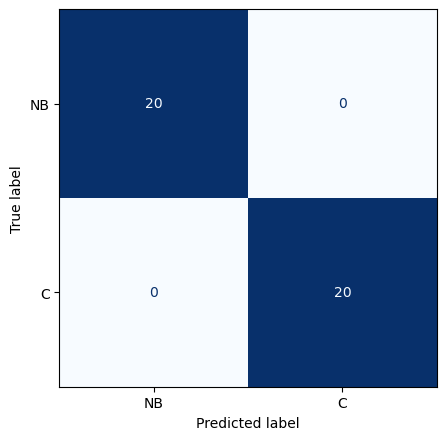

In [46]:
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
ConfusionMatrixDisplay.from_predictions(label_array,prediction_array,display_labels=['NB','C'],cmap='Blues',colorbar=False,ax=ax)
plt.show()

In [49]:
print(classification_report(label_array, prediction_array, digits=4,target_names=['NB','C']))

              precision    recall  f1-score   support

          NB     1.0000    1.0000    1.0000        20
           C     1.0000    1.0000    1.0000        20

    accuracy                         1.0000        40
   macro avg     1.0000    1.0000    1.0000        40
weighted avg     1.0000    1.0000    1.0000        40



Das funktioniert leider nicht. Wie soll man das Modell verbessern, wenn es perfekt funktioniert?
Ansätze:
* Crossvalidation? Geht nicht, weil generierte Bilder aus einem festen Split bestehen
* Neue Bilder (es gibt mehr NB-Bilder) mit dazunehmen? Wird dann unbalanced
* Pneumonia vs nicht-Pneumonia mit allen Bildern betrachten? Dann wäre es cool, wenn Christian nochmal neue Bilder erstellen könnte auf Basis aller Daten
    * Dann gleichen Split nehmen wie für das KD Paper